In [1]:
import numpy as np
from scipy import optimize as op
import matplotlib.pyplot as plt
import pandas as pd
from tinygp import kernels,GaussianProcess
import jax
jax.config.update("jax_enable_x64", True)
SAVE_DIR = './gp_results/'

In [2]:
def xyz(df, t_col='norm_t', d_col='norm_m', e_col='mag_err_all'):
    X = df[t_col].to_numpy(dtype='float64')
    y = df[d_col].to_numpy(dtype='float64')
    y_err = df[e_col].to_numpy(dtype='float64')
    return X,y,y_err

#for mag plots
def plot_gp(X, y, y_err, snid='sn_name',band='all', individ=True):
    kernel = kernels.ExpSquared(scale=3)
    gp = GaussianProcess(kernel, X, diag=y_err)
    # cond = gp.condition(y)

    X_test = np.linspace(min(X)-0.5, max(X)+0.5, 100)
    _, cond_gp = gp.condition(y, X_test)

    # The GP object keeps track of its mean and variance, which we can use for
    # plotting confidence intervals
    mu = cond_gp.mean
    std = np.sqrt(cond_gp.variance)
    if individ:
        plt.figure()
    if band=='all':
        plot_color='darkorange'
    if band=='g':
        plot_color='darkgreen'
        data_color='yellowgreen'
    if band=='r':
        plot_color='firebrick'
        data_color='red'

    plt.plot(X_test, mu, color=plot_color, label="mean")
    plt.fill_between(X_test, (mu - std), (mu + std), color=plot_color, alpha=0.3, label="1-sigma region")

    if individ or band=='all':
        plt.errorbar(X, y, y_err, label=band+" data", linestyle='',marker='o',color='black',markersize=4)
    if not individ and band!='all':
        plt.errorbar(X, y, y_err, label=band+" data", linestyle='',marker='o',color=data_color,markersize=4,markeredgecolor='black')
    plt.legend(fontsize=10)
    plt.xlim(X_test.min(), X_test.max())
    plt.xlabel("Time [days]")
    _ = plt.ylabel("Magnitude")
    plt.title(snid+': '+band+' bands')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.savefig(SAVE_DIR+snid+'_overlap_s1-5.png')
    return #plt.show()

#for mag gp
def do_gp(df, snid='sn_name',band='all',individ=True,subplot=False):
    X,y,y_err = xyz(df)
    if not subplot:
        plot_gp(X,y,y_err,snid=snid,band=band,individ=individ)

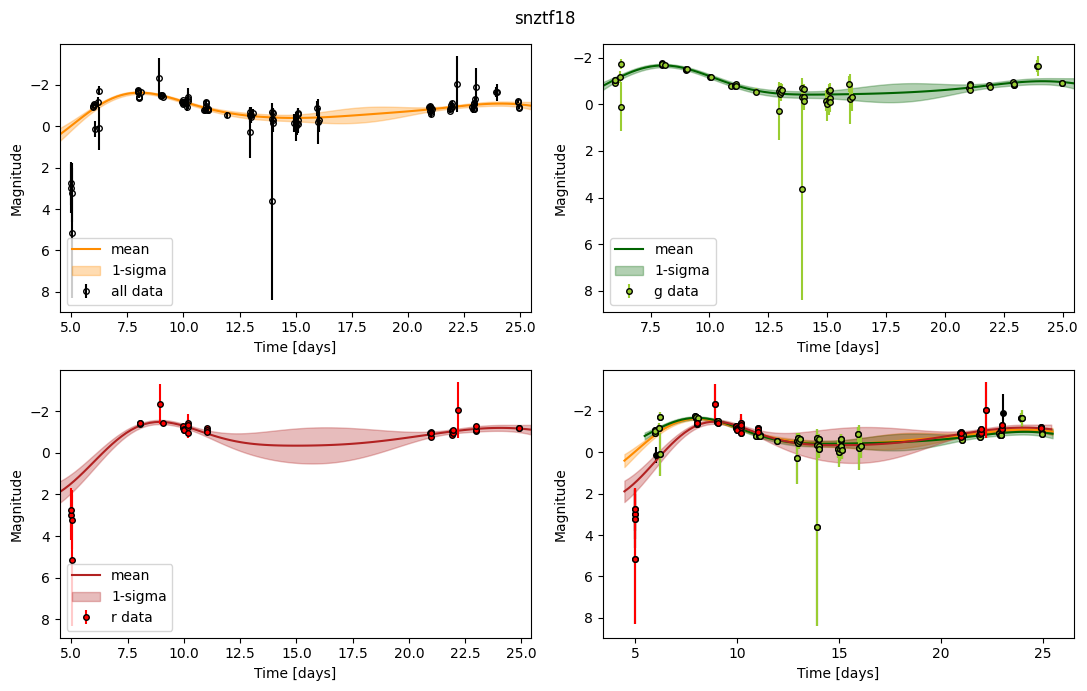

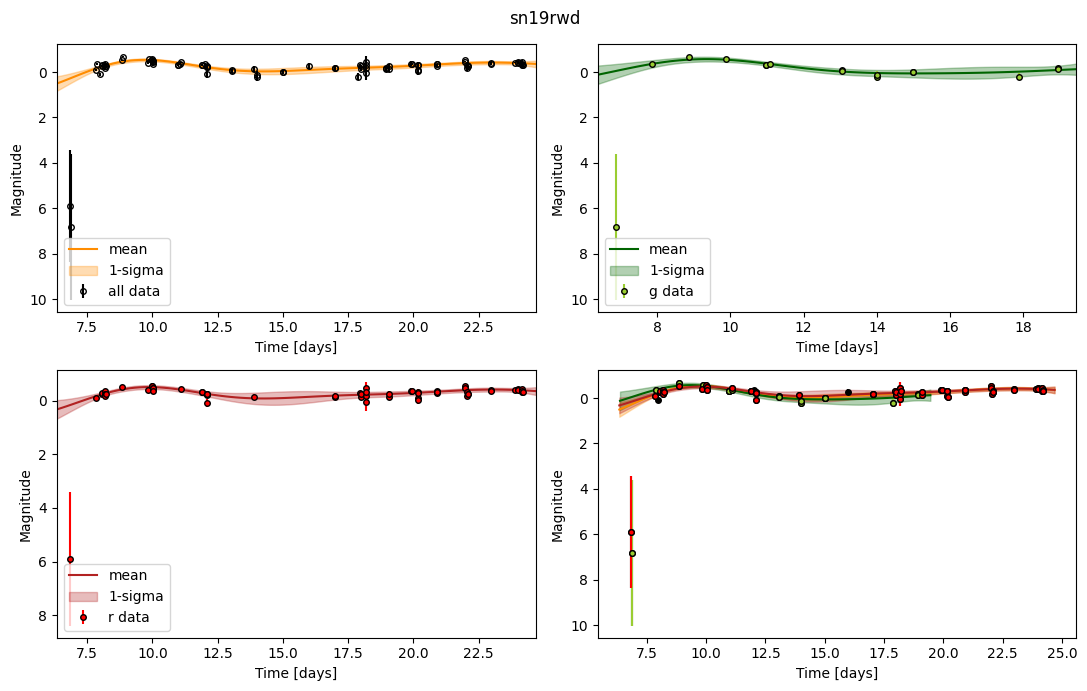

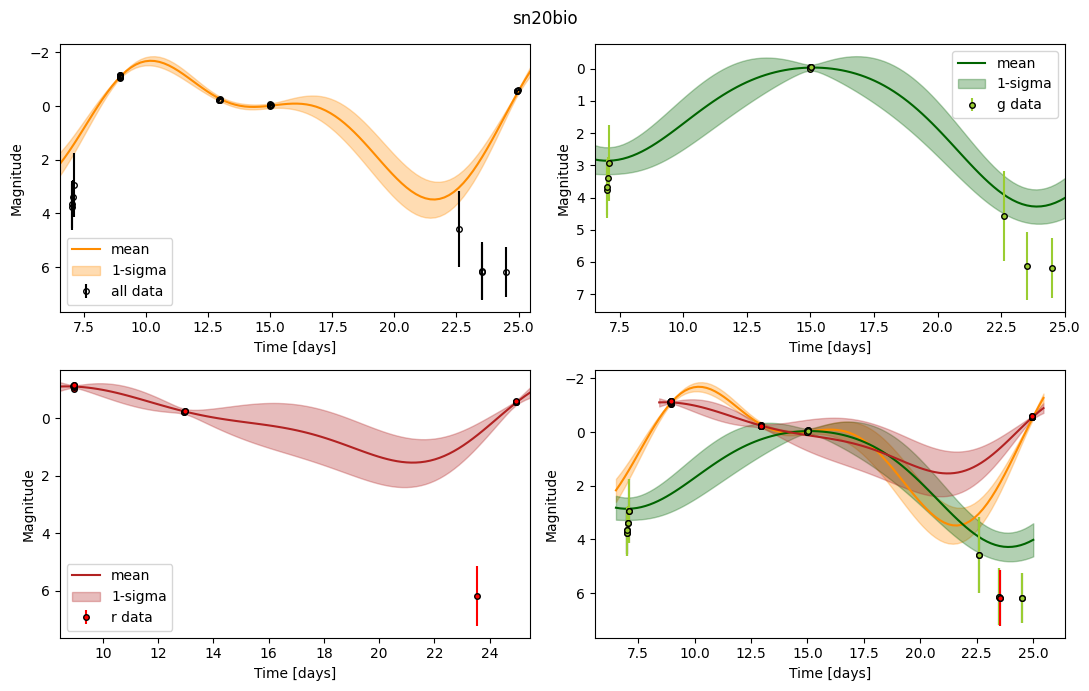

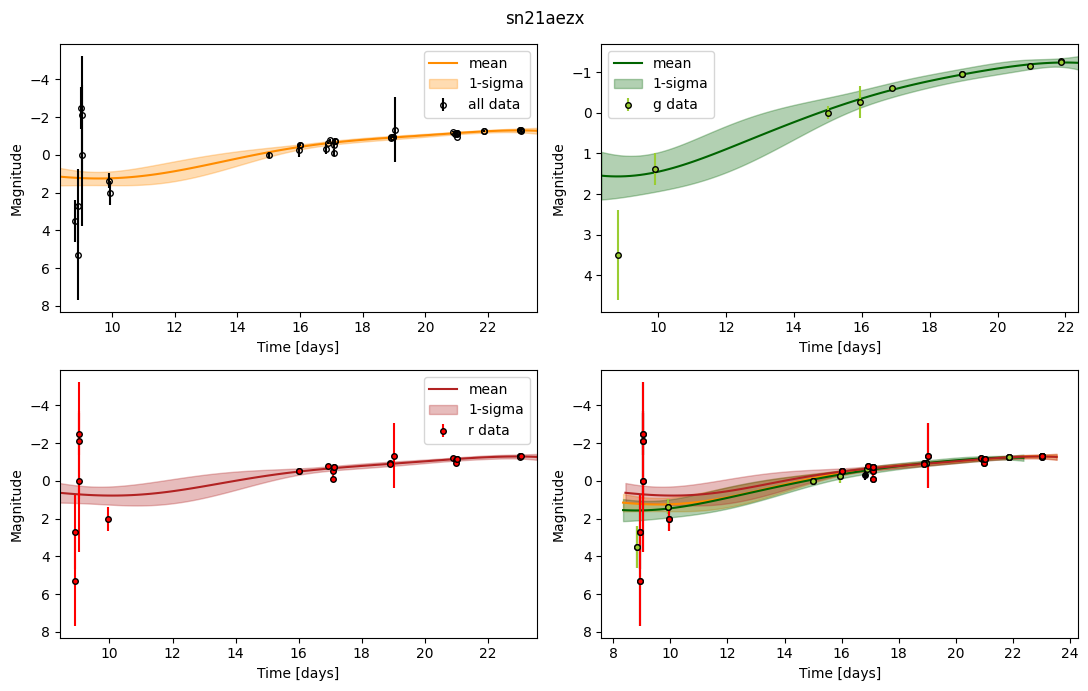

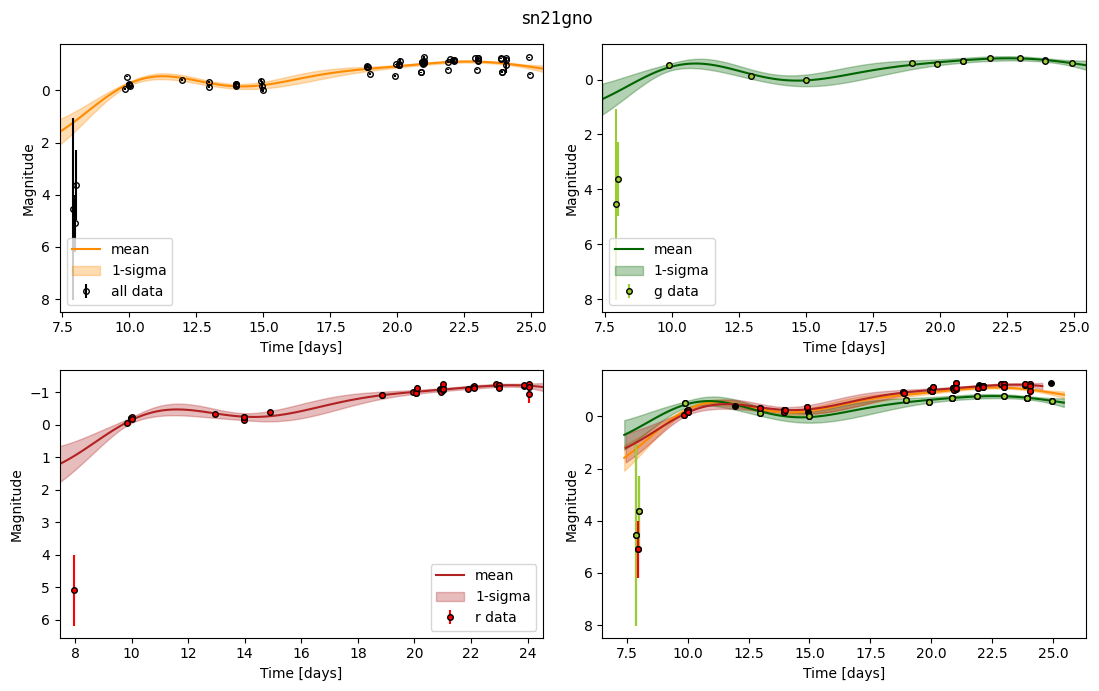

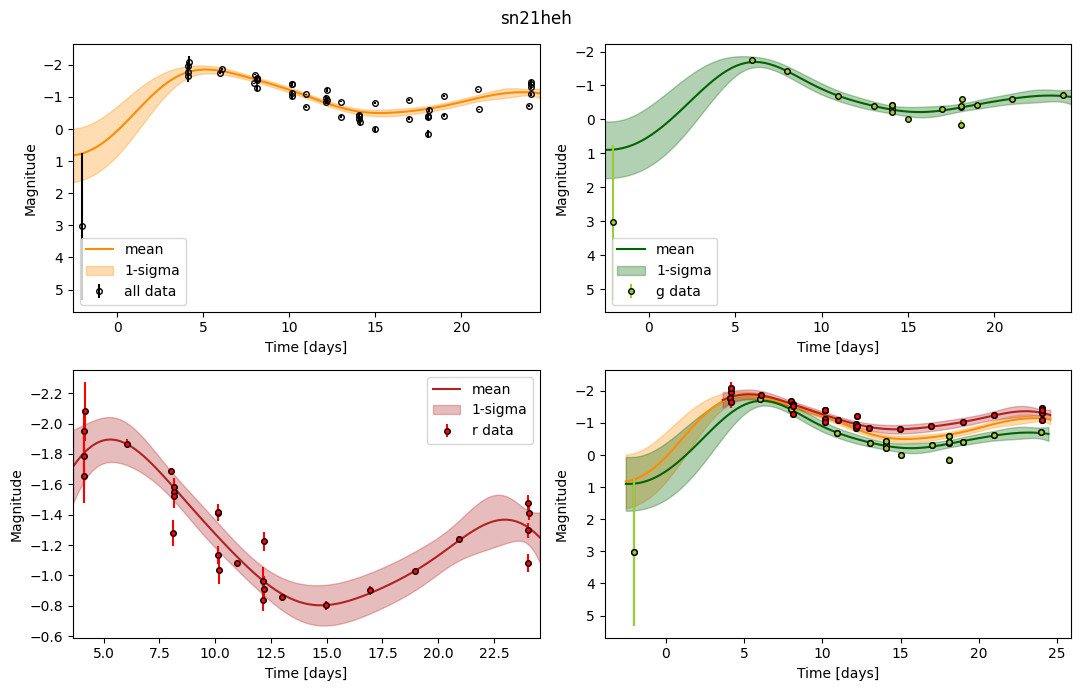

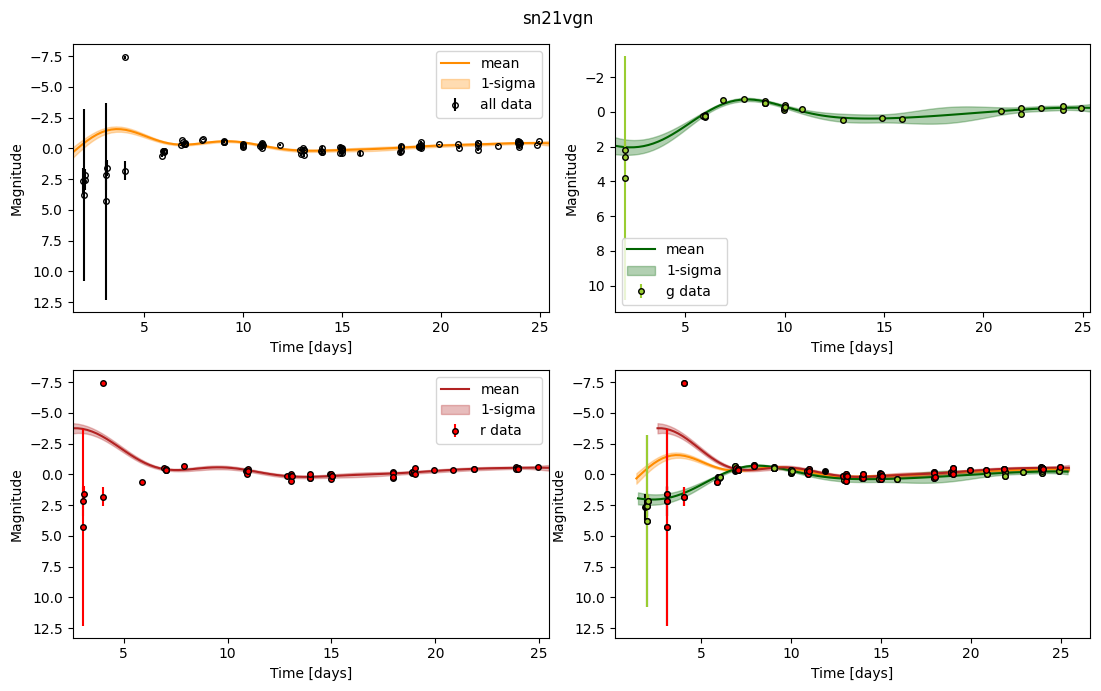

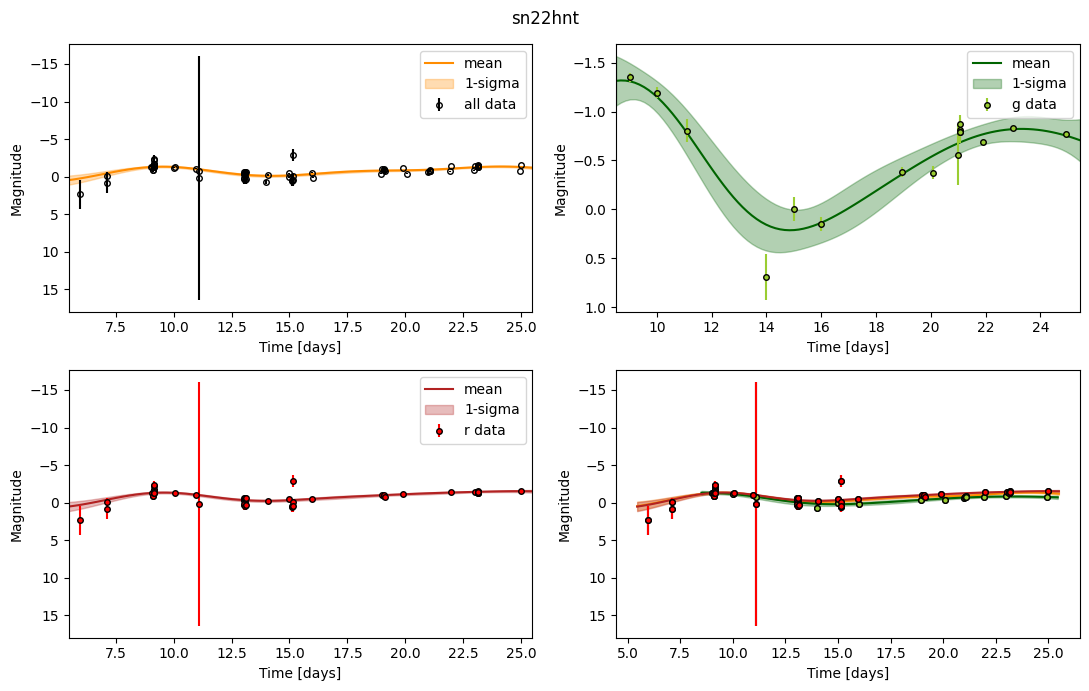

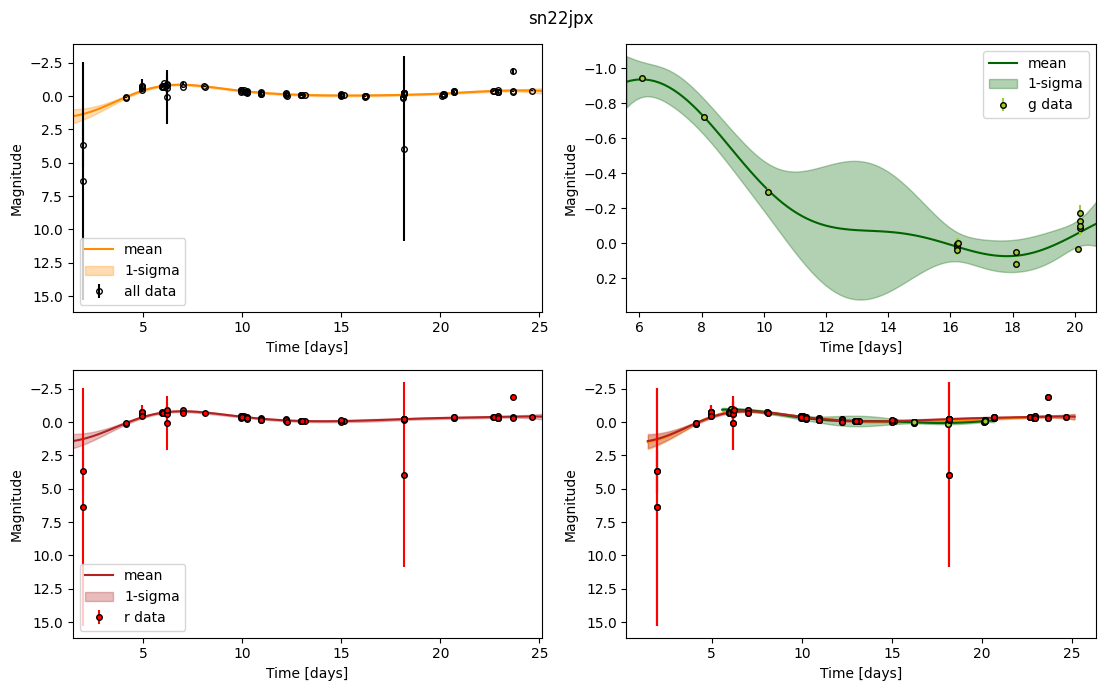

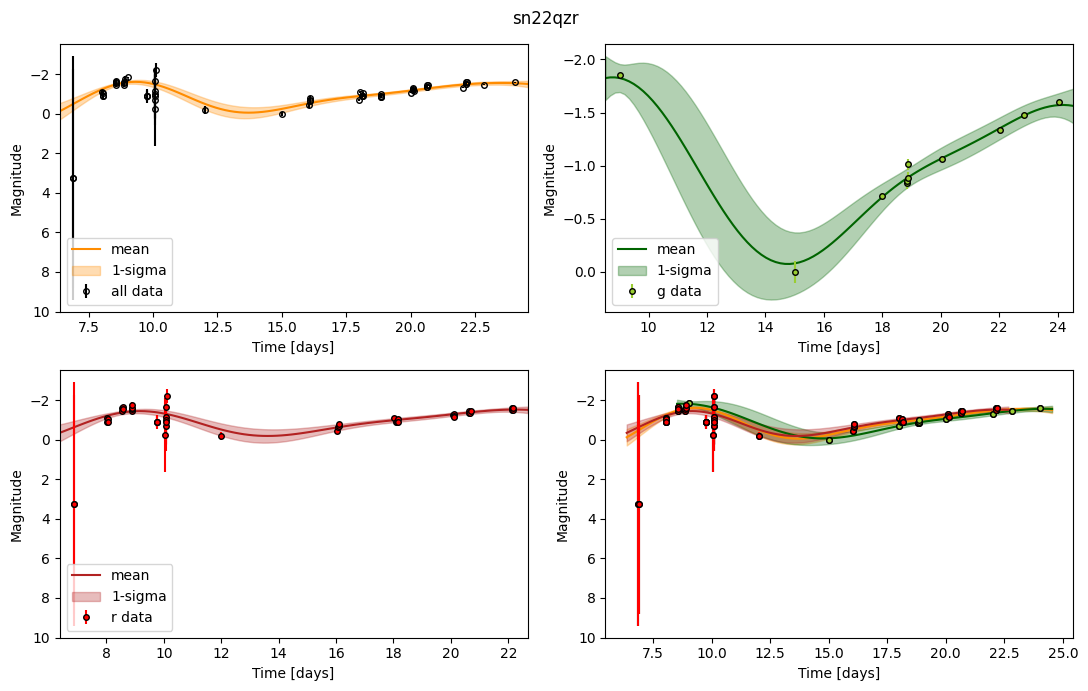

In [3]:
# MAGNITUDE FITTING #
snztf18 = pd.read_csv('./forced_phot_data/subselected_dfs/snztf18.csv')
sn19rwd = pd.read_csv('./forced_phot_data/subselected_dfs/sn19rwd.csv')
sn20bio = pd.read_csv('./forced_phot_data/subselected_dfs/sn20bio.csv')
sn21aezx = pd.read_csv('./forced_phot_data/subselected_dfs/sn21aezx.csv')
sn21gno = pd.read_csv('./forced_phot_data/subselected_dfs/sn21gno.csv')
sn21heh = pd.read_csv('./forced_phot_data/subselected_dfs/sn21heh.csv')
sn21vgn = pd.read_csv('./forced_phot_data/subselected_dfs/sn21vgn.csv')
sn22hnt = pd.read_csv('./forced_phot_data/subselected_dfs/sn22hnt.csv')
sn22jpx = pd.read_csv('./forced_phot_data/subselected_dfs/sn22jpx.csv')
sn22qzr = pd.read_csv('./forced_phot_data/subselected_dfs/sn22qzr.csv')

df_list = [snztf18,sn19rwd,sn20bio,sn21aezx,sn21gno,sn21heh,sn21vgn,sn22hnt,sn22jpx,sn22qzr]
df_str_list = ['snztf18','sn19rwd','sn20bio','sn21aezx','sn21gno','sn21heh','sn21vgn','sn22hnt','sn22jpx','sn22qzr']

# fig.subplots_adjust(hspace=0.4,wspace=0.6)
plot_pos = [[0,0],[0,1],[1,0]] #also, [1,1]
for i,df in enumerate(df_list):
    kernel = kernels.ExpSquared(scale=3)
    g_df = df[(df['filter']=='ZTF_g') | (df['filter']=='c')]
    r_df = df[(df['filter']=='ZTF_r') | (df['filter']=='o')]
    dfs = [df,g_df,r_df]
    bands=['all','g','r']
    fig,ax = plt.subplots(2,2,figsize=(11,7)) 

    for j,d, in enumerate(dfs):
        band=bands[j]
        xloc,yloc = plot_pos[j][0], plot_pos[j][1]

        #do GP
        X,y,y_err=xyz(d)
        gp = GaussianProcess(kernel, X, diag=y_err)
        X_test = np.linspace(min(X)-0.5, max(X)+0.5, 100)
        _, cond_gp = gp.condition(y, X_test)
        mu = cond_gp.mean
        std = np.sqrt(cond_gp.variance)

        #make plots
        if band=='all':
            plot_color='darkorange'
        if band=='g':
            plot_color='darkgreen'
            data_color='yellowgreen'
        if band=='r':
            plot_color='firebrick'
            data_color='red'

        ax[xloc,yloc].plot(X_test, mu, color=plot_color, label="mean")
        ax[xloc,yloc].fill_between(X_test, (mu - std), (mu + std), color=plot_color, alpha=0.3, label="1-sigma")
        ax[1,1].plot(X_test, mu, color=plot_color, label=band+":mean")
        ax[1,1].fill_between(X_test, (mu - std), (mu + std), color=plot_color, alpha=0.3, label=band+":1-sigma")

        if band=='all':
            ax[xloc,yloc].errorbar(X, y, y_err, label=band+" data", linestyle='',marker='o',color='black',markerfacecolor='none',markersize=4)
            ax[1,1].errorbar(X, y, y_err, label=band+" data", linestyle='',marker='o',color='black',markersize=4)
        if band!='all':
            ax[xloc,yloc].errorbar(X, y, y_err, label=band+" data", linestyle='',marker='o',color=data_color,markersize=4,markeredgecolor='black')
            ax[1,1].errorbar(X, y, y_err, label=band+" data", linestyle='',marker='o',color=data_color,markersize=4,markeredgecolor='black')

        ax[xloc,yloc].legend(fontsize=10)
        ax[xloc,yloc].set_xlim(X_test.min(), X_test.max())
        ax[xloc,yloc].set_xlabel("Time [days]")
        _ = ax[xloc,yloc].set_ylabel("Magnitude")
        ax[xloc,yloc].invert_yaxis()
    fig.suptitle(df_str_list[i])
    ax[1,1].invert_yaxis()
    ax[1,1].set_xlabel("Time [days]")
    _ = ax[1,1].set_ylabel("Magnitude")
    plt.tight_layout()
    plt.savefig(SAVE_DIR+df_str_list[i]+'_panel_s3.png')

In [4]:
# FLUX FITTING #

In [5]:
snztf18_f = pd.read_csv('./forced_phot_data/subselected_dfs/snztf18_flux.csv')
sn19rwd_f = pd.read_csv('./forced_phot_data/subselected_dfs/sn19rwd_flux.csv')
# sn20bio = pd.read_csv('./mcmc_fp_results/subselected_dfs/sn20bio.csv')
# sn21aezx = pd.read_csv('./mcmc_fp_results/subselected_dfs/sn21aezx.csv')
# sn21gno = pd.read_csv('./mcmc_fp_results/subselected_dfs/sn21gno.csv')
# sn21heh = pd.read_csv('./mcmc_fp_results/subselected_dfs/sn21heh.csv')
sn21vgn_f = pd.read_csv('./forced_phot_data/subselected_dfs/sn21vgn_flux.csv')
# sn22hnt = pd.read_csv('./mcmc_fp_results/subselected_dfs/sn22hnt.csv')
# sn22jpx = pd.read_csv('./mcmc_fp_results/subselected_dfs/sn22jpx.csv')
# sn22qzr = pd.read_csv('./mcmc_fp_results/subselected_dfs/sn22qzr.csv')

df_list_f = [snztf18_f,sn19rwd_f,sn21vgn_f]
df_str_list_f = ['snztf18','sn19rwd','sn21vgn']
snztf18_f.columns

Index(['field', 'ccdid', 'qid', 'filter', 'pid', 'infobitssci', 'sciinpseeing',
       'scibckgnd', 'scisigpix', 'zpmaginpsci', 'zpmaginpsciunc',
       'zpmaginpscirms', 'clrcoeff', 'clrcoeffunc', 'ncalmatches', 'exptime',
       'adpctdif1', 'adpctdif2', 'diffmaglim', 'zpdiff', 'programid', 'jd',
       'rfid', 'forcediffimflux', 'forcediffimfluxunc', 'forcediffimsnr',
       'forcediffimchisq', 'forcediffimfluxap', 'forcediffimfluxuncap',
       'forcediffimsnrap', 'aperturecorr', 'dnearestrefsrc', 'nearestrefmag',
       'nearestrefmagunc', 'nearestrefchi', 'nearestrefsharp', 'refjdstart',
       'refjdend', 'procstatus', 'mag', 'mag_err_lower', 'mag_err_upper'],
      dtype='object')

6.84865097406581 759.928043049344
6.84865097406581 759.928043049344
23.7629956366069 59.6143920961141
21.2009738234678 131.987178638705
21.2009738234678 131.987178638705
21.5583241360993 102.97933752397
20.5697952367953 60.8519887470464
22.8962120979602 60.8519887470464
21.5040380015678 59.4052427891922


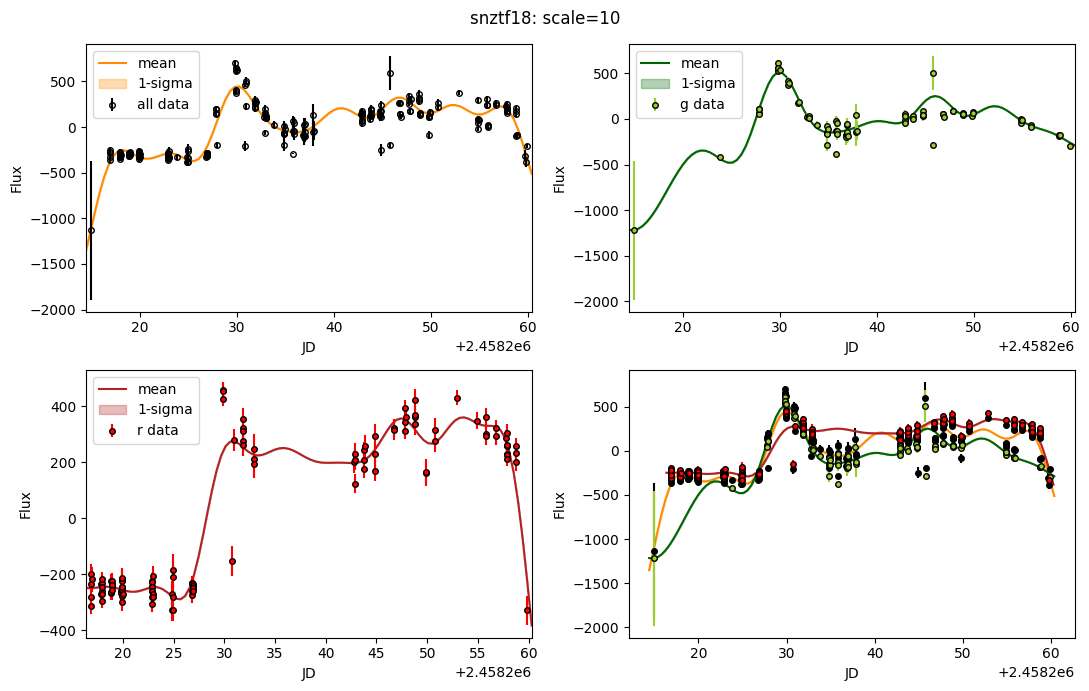

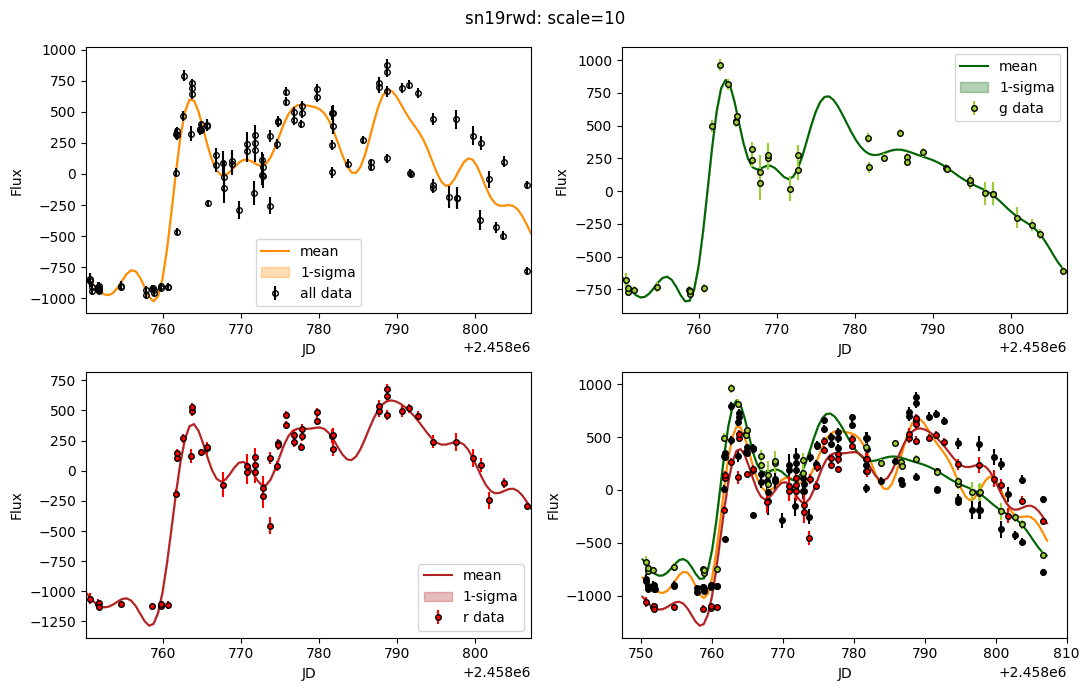

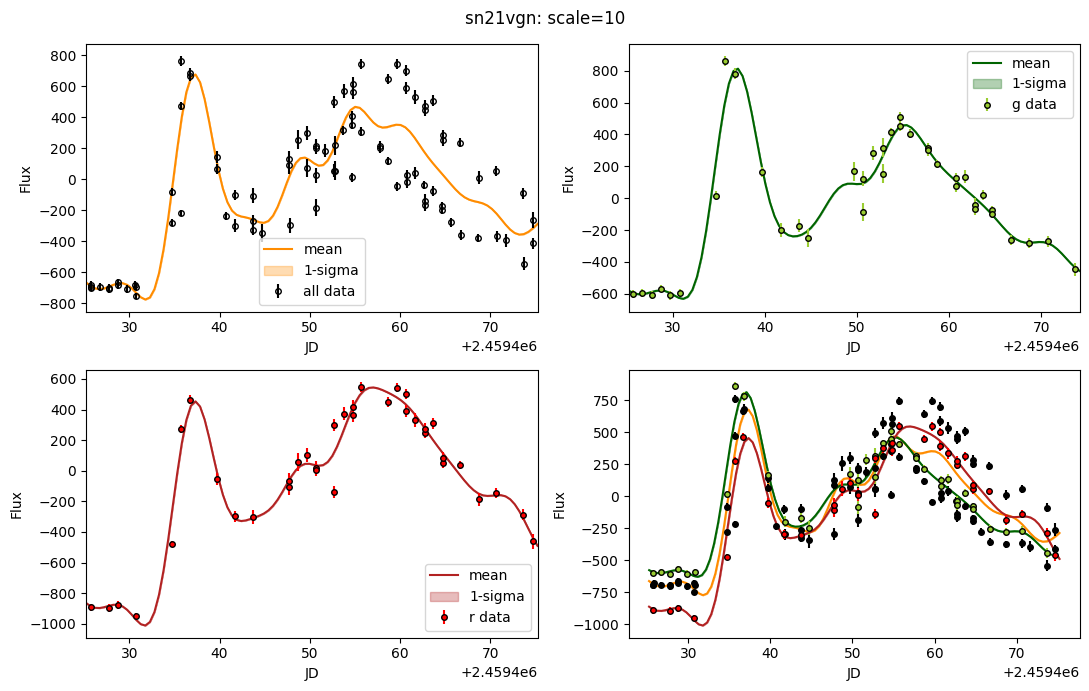

In [25]:
# fig.subplots_adjust(hspace=0.4,wspace=0.6)
plot_pos = [[0,0],[0,1],[1,0]] #also, [1,1]
s = 10 #scale factor
for i,df in enumerate(df_list_f):
    kernel1 = kernels.ExpSquared(scale=3)
    kernel2 = kernels.ExpSquared(scale=10)
    kernel = kernels.Sum(kernel1,kernel2)

    g_df = df[df['filter']=='ZTF_g']
    r_df = df[df['filter']=='ZTF_r']
    dfs = [df,g_df,r_df]
    bands=['all','g','r']
    fig,ax = plt.subplots(2,2,figsize=(11,7)) 

    for j,d, in enumerate(dfs):
        band=bands[j]
        xloc,yloc = plot_pos[j][0], plot_pos[j][1]

        #do GP
        X,y,y_err=xyz(d, t_col='jd', d_col='forcediffimflux', e_col='forcediffimfluxunc')
        # y_norm1 = y/(max(y)-min(y))
        y_norm = y - np.mean(y)
        gp = GaussianProcess(kernel, X, diag=1/y_err)
        print(min(y_err),max(y_err))
        X_test = np.linspace(min(X)-0.5, max(X)+0.5, 100)
        _, cond_gp = gp.condition(y_norm, X_test)
        mu = cond_gp.mean
        std = np.sqrt(cond_gp.variance)

        #make plots
        if band=='all':
            plot_color='darkorange'
        if band=='g':
            plot_color='darkgreen'
            data_color='yellowgreen'
        if band=='r':
            plot_color='firebrick'
            data_color='red'

        ax[xloc,yloc].plot(X_test, mu, color=plot_color, label="mean")
        ax[xloc,yloc].fill_between(X_test, (mu - std), (mu + std), color=plot_color, alpha=0.3, label="1-sigma")
        ax[1,1].plot(X_test, mu, color=plot_color, label=band+":mean")
        ax[1,1].fill_between(X_test, (mu - std), (mu + std), color=plot_color, alpha=0.3, label=band+":1-sigma")

        if band=='all':
            ax[xloc,yloc].errorbar(X, y_norm, y_err, label=band+" data", linestyle='',marker='o',color='black',markerfacecolor='none',markersize=4)
            ax[1,1].errorbar(X, y_norm, y_err, label=band+" data", linestyle='',marker='o',color='black',markersize=4)
        if band!='all':
            ax[xloc,yloc].errorbar(X, y_norm, y_err, label=band+" data", linestyle='',marker='o',color=data_color,markersize=4,markeredgecolor='black')
            ax[1,1].errorbar(X, y_norm, y_err, label=band+" data", linestyle='',marker='o',color=data_color,markersize=4,markeredgecolor='black')

        ax[xloc,yloc].legend(fontsize=10)
        ax[xloc,yloc].set_xlim(X_test.min(), X_test.max())
        ax[xloc,yloc].set_xlabel("JD")
        _ = ax[xloc,yloc].set_ylabel("Flux")
        # ax[xloc,yloc].invert_yaxis()
    fig.suptitle(df_str_list_f[i]+": scale="+str(s))
    # ax[1,1].invert_yaxis()
    ax[1,1].set_xlabel("JD")
    _ = ax[1,1].set_ylabel("Flux")
    plt.tight_layout()
    # plt.savefig(SAVE_DIR+df_str_list_f[i]+'_flux_panel_s'+str(s)+'.png')